In [2]:
import random
import pandas as pd
import cv2
import os
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image,display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix,classification_report

%matplotlib inline

In [3]:
path=os.getcwd()

In [5]:
print(path)

D:\AIML\Assignments_AIML\CNN


In [6]:
fullpath=os.path.join(path,"train")

In [7]:
print(fullpath)

D:\AIML\Assignments_AIML\CNN\train


In [8]:
classes=os.listdir(fullpath)

In [9]:
print(classes)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [10]:
class get_Dataset:
    def __init__(self):
        self.x_fullpath = os.path.join(path,"train")
        self.classes = os.listdir(self.x_fullpath)
        self.x_data = []
        self.y_data = []
        
    def extract_image(self,classes):
        #iterating over individual classes
        for individual_class in classes:
            self.images=os.listdir(os.path.join(self.x_fullpath,individual_class))
            for imagefilename in self.images:
                self.imagefullpath=os.path.join(self.x_fullpath,individual_class,imagefilename)
                self.x_data.append(cv2.resize(cv2.imread(self.imagefullpath),(128,128)))
                self.y_data.append(individual_class)

    def load_data(self):
        i=0
        self.extract_image(self.classes)
        self.x_data=np.array(self.x_data,("float32"))
        encoder=LabelEncoder()
        self.y_data=to_categorical(encoder.fit_transform(self.y_data))
       
        
        print("Data Successfully Loaded")
        return self.x_data,self.y_data    

In [11]:
dataset=get_Dataset()
X,y=dataset.load_data()

Data Successfully Loaded


In [12]:
# Shape of the dataset
print("Shape of Image",X.shape)
print("Labels:",dataset.classes)


Shape of Image (4767, 128, 128, 3)
Labels: ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [13]:
#Split the Dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=42)

In [14]:
#normalize the dataset
X_train/=255
X_test/=255

In [15]:
print("X_train shape:", X_train.shape)
print("Images in X_train:", X_train.shape[0])
print("Images in X_test:", X_test.shape[0])
print("Max value in X_train:", X_train.max())
print("Min value in X_train:", X_train.min())

X_train shape: (3813, 128, 128, 3)
Images in X_train: 3813
Images in X_test: 954
Max value in X_train: 1.0
Min value in X_train: 0.0


In [16]:
#lets print 100 images from train set
def plot_train_data():
    fig=plt.figure(figsize=(20,15))
    for i in range(0,100):
        fig.add_subplot(10,10,i+1)
        plt.imshow(X_train[i][:][:]);

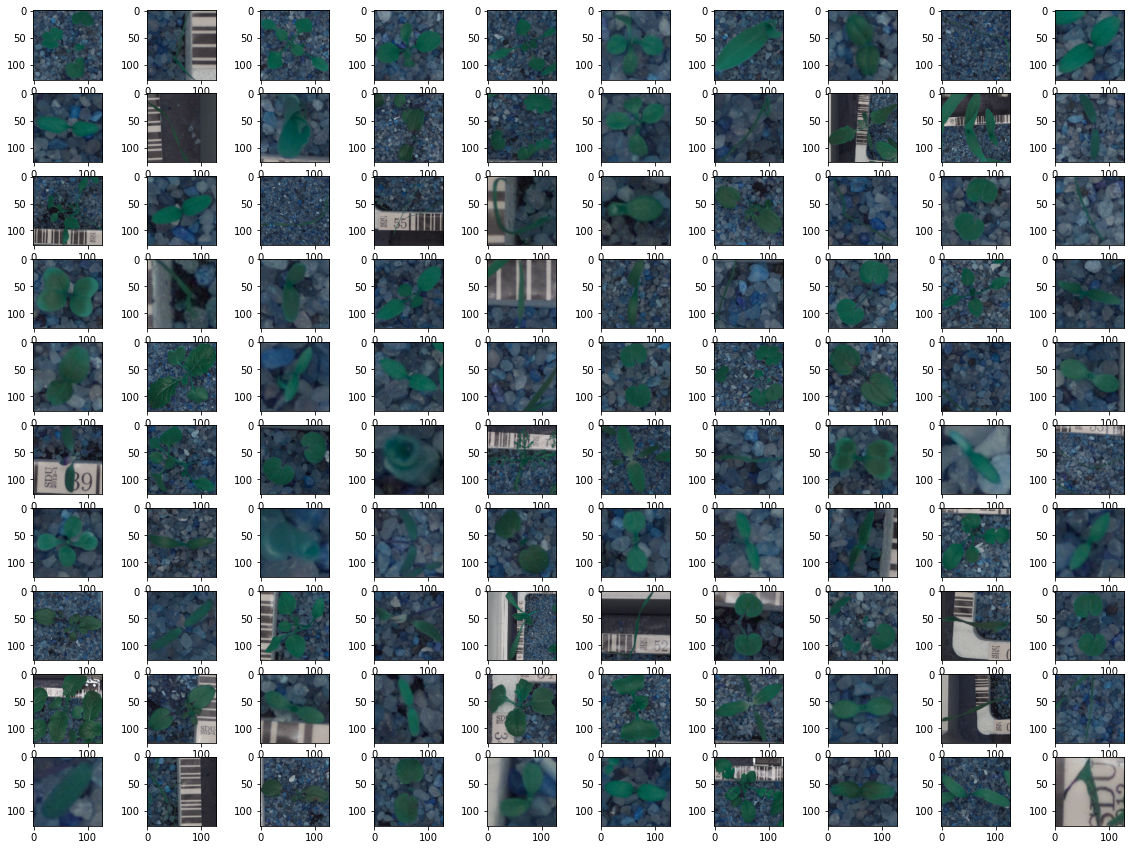

In [27]:
plot_train_data()

## Image Classifier using Neural Network

In [17]:
def plot_history(history,epochs):
    plt.figure()
    plt.plot(np.arange(0,epochs),history["loss"],label="Training loss")
    plt.plot(np.arange(0,epochs),history["val_loss"],label="Test loss")
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Training Loss vs Test loss")
    plt.legend()
    
    plt.figure()
    plt.plot(np.arange(0,epochs),history["accuracy"],label="Training accuracy")
    plt.plot(np.arange(0,epochs),history["val_accuracy"],label="Test accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Loss vs Test loss")
    plt.legend()
    

In [62]:
tf.random.set_seed(42)

def create_model():
    # create model
    model=tf.keras.Sequential([tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(512,kernel_initializer="he_uniform",activation="relu"),
                               
                               tf.keras.layers.Dense(256,kernel_initializer="he_uniform",activation="relu"),
                               
                               tf.keras.layers.Dense(12,kernel_initializer="he_uniform",activation="softmax")])
    #compile the model
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
    return model

print("Generating images...")

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

checkpoint_path=os.path.join(path,"checkpoints")
es=EarlyStopping(monitor="val_loss",min_delta=0.01,patience=50,mode='auto')
mc=ModelCheckpoint(checkpoint_path,monitor="val_loss",mode="auto",save_best_only=True)
lr_schedule=LearningRateScheduler(lambda epoch:0.1*(1-(epoch / float(500))) ** 5)

base_NN=create_model()
history_base=base_NN.fit(aug.flow(X_train,y_train),batch_size=64,validation_data=(X_test,y_test),callbacks=[es,mc,lr_schedule],epochs=500)

Generating images...
Epoch 1/500
120/120 [==============================] - 30s 250ms/step - loss: 7.0782 - accuracy: 0.1374 - val_loss: 2.6845 - val_accuracy: 0.1488
Epoch 2/500
120/120 [==============================] - 29s 240ms/step - loss: 2.4862 - accuracy: 0.1998 - val_loss: 2.4298 - val_accuracy: 0.2683
Epoch 3/500
120/120 [==============================] - 29s 238ms/step - loss: 2.2501 - accuracy: 0.2342 - val_loss: 2.0379 - val_accuracy: 0.3061
Epoch 4/500
120/120 [==============================] - 24s 198ms/step - loss: 2.0836 - accuracy: 0.2738 - val_loss: 2.1304 - val_accuracy: 0.2621
Epoch 5/500
120/120 [==============================] - 29s 239ms/step - loss: 2.0227 - accuracy: 0.2911 - val_loss: 1.9399 - val_accuracy: 0.3312
Epoch 6/500
120/120 [==============================] - 23s 195ms/step - loss: 2.0656 - accuracy: 0.2741 - val_loss: 2.0095 - val_accuracy: 0.3291
Epoch 7/500
120/120 [==============================] - 28s 237ms/step - loss: 1.9180 - accuracy: 0.3145

120/120 [==============================] - 29s 239ms/step - loss: 1.4791 - accuracy: 0.4673 - val_loss: 1.3411 - val_accuracy: 0.5199
Epoch 43/500
120/120 [==============================] - 24s 196ms/step - loss: 1.4990 - accuracy: 0.4532 - val_loss: 1.4943 - val_accuracy: 0.4528
Epoch 44/500
120/120 [==============================] - 23s 195ms/step - loss: 1.4824 - accuracy: 0.4715 - val_loss: 1.4696 - val_accuracy: 0.4486
Epoch 45/500
120/120 [==============================] - 23s 194ms/step - loss: 1.4843 - accuracy: 0.4642 - val_loss: 1.4004 - val_accuracy: 0.4948
Epoch 46/500
120/120 [==============================] - 24s 198ms/step - loss: 1.4882 - accuracy: 0.4663 - val_loss: 1.4389 - val_accuracy: 0.4864
Epoch 47/500
120/120 [==============================] - 23s 194ms/step - loss: 1.4921 - accuracy: 0.4613 - val_loss: 1.6064 - val_accuracy: 0.3973
Epoch 48/500
120/120 [==============================] - 23s 194ms/step - loss: 1.5054 - accuracy: 0.4500 - val_loss: 1.4590 - val_a

Epoch 91/500
120/120 [==============================] - 24s 196ms/step - loss: 1.3987 - accuracy: 0.4896 - val_loss: 1.2975 - val_accuracy: 0.5273
Epoch 92/500
120/120 [==============================] - 24s 197ms/step - loss: 1.3721 - accuracy: 0.5046 - val_loss: 1.2984 - val_accuracy: 0.5325
Epoch 93/500
120/120 [==============================] - 24s 196ms/step - loss: 1.4215 - accuracy: 0.4786 - val_loss: 1.3300 - val_accuracy: 0.5115
Epoch 94/500
120/120 [==============================] - 24s 196ms/step - loss: 1.3725 - accuracy: 0.4951 - val_loss: 1.2931 - val_accuracy: 0.5252
Epoch 95/500
120/120 [==============================] - 24s 198ms/step - loss: 1.4318 - accuracy: 0.4805 - val_loss: 1.3379 - val_accuracy: 0.5283
Epoch 96/500
120/120 [==============================] - 23s 196ms/step - loss: 1.3943 - accuracy: 0.4975 - val_loss: 1.3016 - val_accuracy: 0.5136
Epoch 97/500
120/120 [==============================] - 24s 197ms/step - loss: 1.4122 - accuracy: 0.4925 - val_loss: 1

Epoch 142/500
120/120 [==============================] - 24s 198ms/step - loss: 1.3316 - accuracy: 0.5190 - val_loss: 1.2749 - val_accuracy: 0.5356
Epoch 143/500
120/120 [==============================] - 24s 197ms/step - loss: 1.3425 - accuracy: 0.5012 - val_loss: 1.4332 - val_accuracy: 0.4727
Epoch 144/500
120/120 [==============================] - 24s 198ms/step - loss: 1.3658 - accuracy: 0.5049 - val_loss: 1.2928 - val_accuracy: 0.5273
Epoch 145/500
120/120 [==============================] - 24s 197ms/step - loss: 1.3514 - accuracy: 0.5083 - val_loss: 1.3635 - val_accuracy: 0.5136
Epoch 146/500
120/120 [==============================] - 24s 200ms/step - loss: 1.3153 - accuracy: 0.5201 - val_loss: 1.3107 - val_accuracy: 0.5210
Epoch 147/500
120/120 [==============================] - 23s 196ms/step - loss: 1.3483 - accuracy: 0.5161 - val_loss: 1.2512 - val_accuracy: 0.5482
Epoch 148/500
120/120 [==============================] - 24s 197ms/step - loss: 1.3422 - accuracy: 0.5130 - val_

In [29]:
base_NN.evaluate(X_test,y_test)

30/30 [==============================] - 1s 38ms/step - loss: 1.2526 - accuracy: 0.5283


[1.252584457397461, 0.5283018946647644]

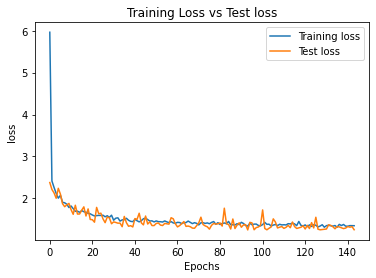

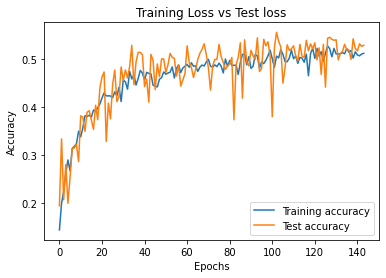

In [32]:
import pandas as pd
plot_history(pd.DataFrame(history_base.history),144)

### Ploting learning rate vs training loss

In [34]:
lrs=0.1*(1-(tf.range(144)/ 500)) ** 5

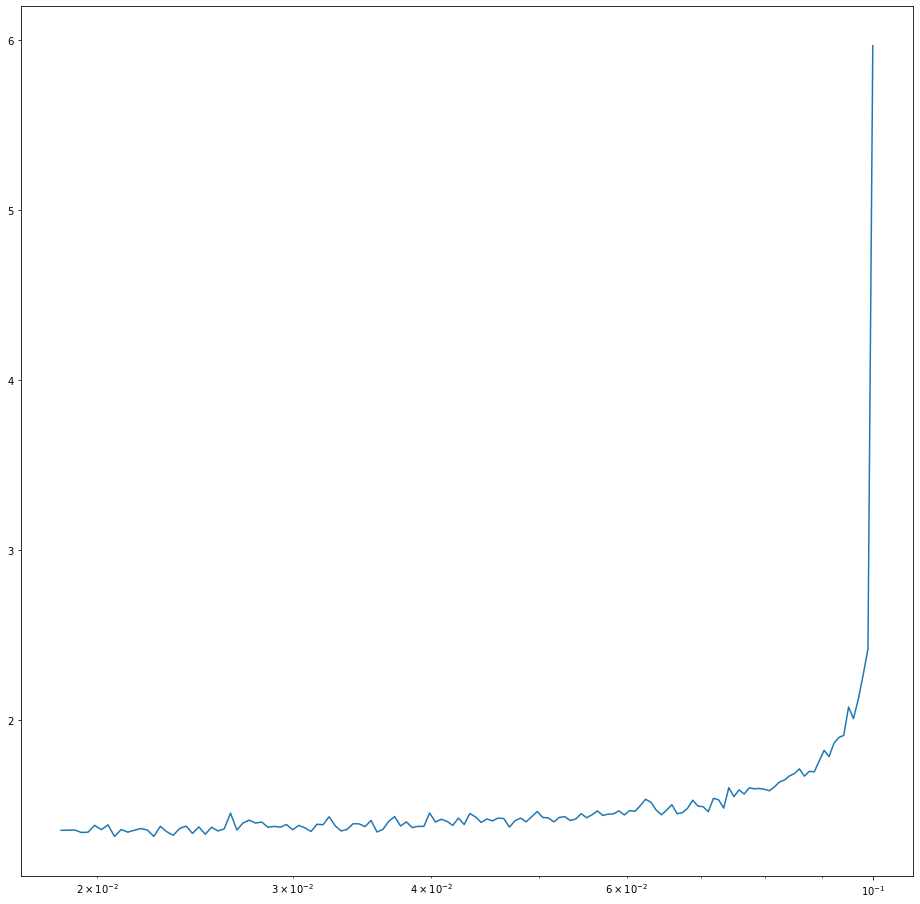

In [41]:
plt.figure(figsize=(16,16))
plt.semilogx(lrs,history_base.history["loss"])

In [21]:
base_model=tf.keras.models.load_model("checkpoints")
base_model.evaluate(X_test,y_test)

30/30 [==============================] - 2s 81ms/step - loss: 1.2288 - accuracy: 0.5461


[1.2287821769714355, 0.5461215972900391]

## Tune batch size and epochs using keras_tuner

In [49]:
import keras_tuner as kt

In [50]:
def build_model(hp):
    
  
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
    hp_units1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    hp_units2 = hp.Int('units2', min_value=32, max_value=512, step=32)
   
    # cretae the model   
    model = tf.keras.Sequential([tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(units=hp_units1,kernel_initializer="he_uniform", activation='relu'),
                                 tf.keras.layers.Dense(units=hp_units2, kernel_initializer="he_uniform",activation='relu'),
                                 tf.keras.layers.Dense(12, kernel_initializer="he_uniform",activation='softmax')])
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    # compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.categorical_crossentropy,
                  metrics=["accuracy"])
    
    return model
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")


es=EarlyStopping(monitor="val_loss",min_delta=0,patience=50,mode='auto')

tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory="tuned_model",
                     project_name='intro_to_kt1')
# Hyperband determines the number of models to train in a bracket by computing 1 + logfactor(max_epochs) and rounding it up to the nearest integer.
tuner.search(aug.flow(X_train,y_train),batch_size=64,validation_data=(X_test,y_test),callbacks=[es],epochs=500)

Trial 30 Complete [00h 07m 38s]
val_accuracy: 0.3050314486026764

Best val_accuracy So Far: 0.4716981053352356
Total elapsed time: 01h 22m 09s
INFO:tensorflow:Oracle triggered exit


In [54]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]

print("The hyperparameter search is complete.")
print("The optimal number of units in the first densely-connected layer is {}".format(best_hps.get("units1")))
print("The optimal number of units in the second densely-connected layer is {}".format(best_hps.get("units2")))
print("the optimal learning rate for the optimizer is{}".format(best_hps.get("learning_rate")))



The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 224
The optimal number of units in the second densely-connected layer is 352
the optimal learning rate for the optimizer is0.0001


### Train the model
Find the optimal number of epochs to train the model with the hyperparameters obtained from the search.

In [58]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
es=EarlyStopping(monitor="val_loss",min_delta=0,patience=50,mode='auto')
#model Checkpoint
checkpoint_path=os.path.join(path,"checkpoints1")
mc1=ModelCheckpoint(checkpoint_path,monitor="val_loss",mode="auto",save_best_only=True)
model = tuner.hypermodel.build(best_hps)
history_tuned = model.fit(aug.flow(X_train,y_train),batch_size=64,validation_data=(X_test,y_test),callbacks=[es,mc1],epochs=500)


Epoch 1/500
120/120 [==============================] - ETA: 0s - loss: 2.4837 - accuracy: 0.1576WARNING:tensorflow:From C:\Users\minak\anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: D:\AIML\Assignments_AIML\CNN\checkpoints1\assets
120/120 [==============================] - 22s 184ms/step - loss: 2.4837 - accuracy: 0.1576 - val_loss: 2.3103 - val_accuracy: 0.2086
Epoch 2/500
120/120 [==============================] - 21s 175ms/step - loss: 2.2885 - accuracy: 0.2127 - val_loss: 2.2157 - val_accuracy: 0.2725
Epoch 3/500
120/120 [==============================] - 21s 177ms

120/120 [==============================] - 21s 175ms/step - loss: 1.4965 - accuracy: 0.4713 - val_loss: 1.3998 - val_accuracy: 0.5063
Epoch 30/500
120/120 [==============================] - 18s 153ms/step - loss: 1.5025 - accuracy: 0.4679 - val_loss: 1.6760 - val_accuracy: 0.3700
Epoch 31/500
120/120 [==============================] - 18s 153ms/step - loss: 1.4778 - accuracy: 0.4862 - val_loss: 1.5037 - val_accuracy: 0.4843
Epoch 32/500
120/120 [==============================] - 18s 152ms/step - loss: 1.4823 - accuracy: 0.4755 - val_loss: 1.4993 - val_accuracy: 0.4507
Epoch 33/500
120/120 [==============================] - 21s 177ms/step - loss: 1.4794 - accuracy: 0.4828 - val_loss: 1.3775 - val_accuracy: 0.5063
Epoch 34/500
120/120 [==============================] - 18s 153ms/step - loss: 1.4695 - accuracy: 0.4794 - val_loss: 1.4232 - val_accuracy: 0.5021
Epoch 35/500
120/120 [==============================] - 21s 177ms/step - loss: 1.4679 - accuracy: 0.4812 - val_loss: 1.3460 - val_a

Epoch 76/500
120/120 [==============================] - 18s 152ms/step - loss: 1.3160 - accuracy: 0.5376 - val_loss: 1.2926 - val_accuracy: 0.5304
Epoch 77/500
120/120 [==============================] - 18s 154ms/step - loss: 1.3326 - accuracy: 0.5337 - val_loss: 1.2867 - val_accuracy: 0.5262
Epoch 78/500
120/120 [==============================] - 21s 173ms/step - loss: 1.3085 - accuracy: 0.5363 - val_loss: 1.2214 - val_accuracy: 0.5545
Epoch 79/500
120/120 [==============================] - 19s 158ms/step - loss: 1.3296 - accuracy: 0.5319 - val_loss: 1.3073 - val_accuracy: 0.5451
Epoch 80/500
120/120 [==============================] - 21s 171ms/step - loss: 1.3380 - accuracy: 0.5392 - val_loss: 1.2774 - val_accuracy: 0.5629
Epoch 81/500
120/120 [==============================] - 20s 170ms/step - loss: 1.3154 - accuracy: 0.5327 - val_loss: 1.4105 - val_accuracy: 0.4969
Epoch 82/500
120/120 [==============================] - 20s 167ms/step - loss: 1.3161 - accuracy: 0.5400 - val_loss: 1

120/120 [==============================] - 23s 194ms/step - loss: 1.2192 - accuracy: 0.5699 - val_loss: 1.1554 - val_accuracy: 0.5881
Epoch 127/500
120/120 [==============================] - 18s 153ms/step - loss: 1.2393 - accuracy: 0.5736 - val_loss: 1.2082 - val_accuracy: 0.5744
Epoch 128/500
120/120 [==============================] - 18s 153ms/step - loss: 1.2332 - accuracy: 0.5646 - val_loss: 1.1985 - val_accuracy: 0.5618
Epoch 129/500
120/120 [==============================] - 18s 151ms/step - loss: 1.2489 - accuracy: 0.5610 - val_loss: 1.2432 - val_accuracy: 0.5545
Epoch 130/500
120/120 [==============================] - 18s 153ms/step - loss: 1.2264 - accuracy: 0.5728 - val_loss: 1.1783 - val_accuracy: 0.5818
Epoch 131/500
120/120 [==============================] - 18s 153ms/step - loss: 1.2739 - accuracy: 0.5560 - val_loss: 1.2522 - val_accuracy: 0.5639
Epoch 132/500
120/120 [==============================] - 18s 153ms/step - loss: 1.2081 - accuracy: 0.5678 - val_loss: 1.1672 -

120/120 [==============================] - 18s 152ms/step - loss: 1.1787 - accuracy: 0.5862 - val_loss: 1.1211 - val_accuracy: 0.6006
Epoch 179/500
120/120 [==============================] - 19s 155ms/step - loss: 1.1781 - accuracy: 0.5883 - val_loss: 1.1479 - val_accuracy: 0.5891
Epoch 180/500
120/120 [==============================] - 18s 152ms/step - loss: 1.1599 - accuracy: 0.5977 - val_loss: 1.1970 - val_accuracy: 0.5797
Epoch 181/500
120/120 [==============================] - 18s 154ms/step - loss: 1.1733 - accuracy: 0.5833 - val_loss: 1.1410 - val_accuracy: 0.5786
Epoch 182/500
120/120 [==============================] - 18s 152ms/step - loss: 1.1636 - accuracy: 0.5919 - val_loss: 1.1158 - val_accuracy: 0.6038
Epoch 183/500
120/120 [==============================] - 18s 152ms/step - loss: 1.1658 - accuracy: 0.5927 - val_loss: 1.1654 - val_accuracy: 0.5839
Epoch 184/500
120/120 [==============================] - 18s 153ms/step - loss: 1.1392 - accuracy: 0.5966 - val_loss: 1.1223 -

Epoch 229/500
120/120 [==============================] - 23s 192ms/step - loss: 1.1267 - accuracy: 0.5959 - val_loss: 1.0823 - val_accuracy: 0.6122
Epoch 230/500
120/120 [==============================] - 18s 153ms/step - loss: 1.1096 - accuracy: 0.6082 - val_loss: 1.1067 - val_accuracy: 0.6111
Epoch 231/500
120/120 [==============================] - 18s 152ms/step - loss: 1.1275 - accuracy: 0.6027 - val_loss: 1.1219 - val_accuracy: 0.5818
Epoch 232/500
120/120 [==============================] - 18s 152ms/step - loss: 1.1433 - accuracy: 0.6024 - val_loss: 1.0977 - val_accuracy: 0.6132
Epoch 233/500
120/120 [==============================] - 18s 153ms/step - loss: 1.1449 - accuracy: 0.5961 - val_loss: 1.2157 - val_accuracy: 0.5618
Epoch 234/500
120/120 [==============================] - 18s 152ms/step - loss: 1.1366 - accuracy: 0.5953 - val_loss: 1.1288 - val_accuracy: 0.5943
Epoch 235/500
120/120 [==============================] - 21s 178ms/step - loss: 1.1120 - accuracy: 0.6116 - val_

Epoch 279/500
120/120 [==============================] - 18s 153ms/step - loss: 1.0872 - accuracy: 0.6195 - val_loss: 1.0926 - val_accuracy: 0.6184
Epoch 280/500
120/120 [==============================] - 18s 152ms/step - loss: 1.1016 - accuracy: 0.6092 - val_loss: 1.0757 - val_accuracy: 0.6195
Epoch 281/500
120/120 [==============================] - 18s 153ms/step - loss: 1.0904 - accuracy: 0.6184 - val_loss: 1.1336 - val_accuracy: 0.5985
Epoch 282/500
120/120 [==============================] - 18s 153ms/step - loss: 1.0836 - accuracy: 0.6176 - val_loss: 1.1078 - val_accuracy: 0.5901
Epoch 283/500
120/120 [==============================] - 18s 153ms/step - loss: 1.0958 - accuracy: 0.6166 - val_loss: 1.0984 - val_accuracy: 0.6080
Epoch 284/500
120/120 [==============================] - 18s 152ms/step - loss: 1.0804 - accuracy: 0.6113 - val_loss: 1.1411 - val_accuracy: 0.6059
Epoch 285/500
120/120 [==============================] - 18s 154ms/step - loss: 1.1030 - accuracy: 0.6048 - val_

120/120 [==============================] - 18s 152ms/step - loss: 1.0229 - accuracy: 0.6344 - val_loss: 1.1387 - val_accuracy: 0.6006
Epoch 387/500
120/120 [==============================] - 19s 155ms/step - loss: 1.0307 - accuracy: 0.6404 - val_loss: 1.2240 - val_accuracy: 0.5702
Epoch 388/500
120/120 [==============================] - 18s 153ms/step - loss: 1.0100 - accuracy: 0.6391 - val_loss: 1.0268 - val_accuracy: 0.6509
Epoch 389/500
120/120 [==============================] - 18s 153ms/step - loss: 1.0221 - accuracy: 0.6344 - val_loss: 1.0268 - val_accuracy: 0.6405
Epoch 390/500
120/120 [==============================] - 18s 152ms/step - loss: 1.0010 - accuracy: 0.6457 - val_loss: 1.0601 - val_accuracy: 0.6310
Epoch 391/500
120/120 [==============================] - 18s 154ms/step - loss: 1.0160 - accuracy: 0.6499 - val_loss: 1.1716 - val_accuracy: 0.5954
Epoch 392/500
120/120 [==============================] - 18s 152ms/step - loss: 1.0151 - accuracy: 0.6509 - val_loss: 1.0684 -

In [59]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 0s 13ms/step - loss: 1.0305 - accuracy: 0.6426


[1.0304627418518066, 0.642557680606842]

In [19]:
saved_model=tf.keras.models.load_model("checkpoints1/")

In [20]:
saved_model.evaluate(X_test,y_test)

30/30 [==============================] - 1s 38ms/step - loss: 1.0015 - accuracy: 0.6509


[1.0014852285385132, 0.650943398475647]

In [24]:

tf.random.set_seed(42)
def create_model2():
    # create model
    model=tf.keras.Sequential([ tf.keras.layers.Conv2D(32,5,padding="same",activation="relu"),
                                tf.keras.layers.MaxPool2D(),
                                tf.keras.layers.Conv2D(64,3,padding="same",activation="relu"),
                                tf.keras.layers.MaxPool2D(),
                                tf.keras.layers.Conv2D(64,3,padding="same",activation="relu"),
                                tf.keras.layers.MaxPool2D(),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(128,kernel_initializer="he_uniform",activation="relu"),
                                tf.keras.layers.Dense(128,kernel_initializer="he_uniform",activation="relu"),
                                tf.keras.layers.Dense(12,kernel_initializer="he_uniform",activation="softmax")                                                         
                               ])
    #compile the model
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
    return model

aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
                         horizontal_flip=True, fill_mode="nearest")
# early stopping
es=EarlyStopping(monitor="val_loss",min_delta=0.01,patience=50,mode='auto')


#model Checkpoint
checkpoint_path=os.path.join(path,"checkpoints_cnn")
mc2=ModelCheckpoint(checkpoint_path,monitor="val_loss",mode="auto",save_best_only=True)
model_CNN=create_model2()
history_CNN=model_CNN.fit(aug.flow(X_train,y_train),validation_data=(X_test,y_test),callbacks=[es,mc2],epochs=500)


Epoch 1/500
120/120 [==============================] - 130s 1s/step - loss: 2.2536 - accuracy: 0.2172 - val_loss: 1.8581 - val_accuracy: 0.3323
Epoch 2/500
120/120 [==============================] - 123s 1s/step - loss: 1.6795 - accuracy: 0.4039 - val_loss: 1.4372 - val_accuracy: 0.4822
Epoch 3/500
120/120 [==============================] - 115s 962ms/step - loss: 1.4843 - accuracy: 0.4765 - val_loss: 1.2662 - val_accuracy: 0.5650
Epoch 4/500
120/120 [==============================] - 114s 951ms/step - loss: 1.3033 - accuracy: 0.5471 - val_loss: 1.0964 - val_accuracy: 0.6268
Epoch 5/500
120/120 [==============================] - 121s 1s/step - loss: 1.1418 - accuracy: 0.5982 - val_loss: 1.0394 - val_accuracy: 0.6373
Epoch 6/500
120/120 [==============================] - 124s 1s/step - loss: 1.0279 - accuracy: 0.6525 - val_loss: 0.8548 - val_accuracy: 0.7222
Epoch 7/500
120/120 [==============================] - 120s 998ms/step - loss: 0.9555 - accuracy: 0.6758 - val_loss: 0.7216 - val_

120/120 [==============================] - 92s 764ms/step - loss: 0.2960 - accuracy: 0.8922 - val_loss: 0.3399 - val_accuracy: 0.8711
Epoch 38/500
120/120 [==============================] - 93s 773ms/step - loss: 0.3221 - accuracy: 0.8752 - val_loss: 0.2993 - val_accuracy: 0.9015
Epoch 39/500
120/120 [==============================] - 95s 794ms/step - loss: 0.2791 - accuracy: 0.8964 - val_loss: 0.4651 - val_accuracy: 0.8249
Epoch 40/500
120/120 [==============================] - 89s 744ms/step - loss: 0.2981 - accuracy: 0.8938 - val_loss: 0.4287 - val_accuracy: 0.8501
Epoch 41/500
120/120 [==============================] - 89s 742ms/step - loss: 0.2837 - accuracy: 0.8980 - val_loss: 0.3194 - val_accuracy: 0.8878
Epoch 42/500
120/120 [==============================] - 92s 769ms/step - loss: 0.2513 - accuracy: 0.9066 - val_loss: 0.2814 - val_accuracy: 0.9004
Epoch 43/500
120/120 [==============================] - 84s 700ms/step - loss: 0.2336 - accuracy: 0.9137 - val_loss: 0.2965 - val_a

In [25]:
model_CNN.evaluate(X_test,y_test)

30/30 [==============================] - 5s 151ms/step - loss: 0.2555 - accuracy: 0.9182


[0.25551119446754456, 0.9182389974594116]

In [22]:
saved_model3=tf.keras.models.load_model("checkpoints_cnn/")

In [23]:
saved_model3.evaluate(X_test,y_test)

30/30 [==============================] - 12s 388ms/step - loss: 0.2542 - accuracy: 0.9025


[0.25417858362197876, 0.902515709400177]

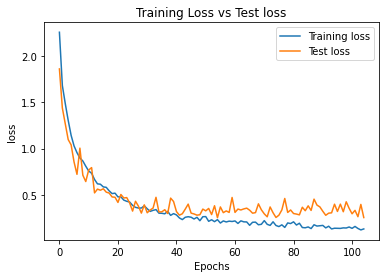

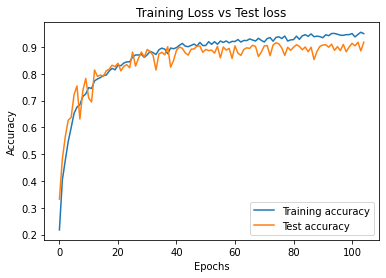

In [31]:
plot_history(pd.DataFrame(history_CNN.history),105)

## Transfer Learning
- using ResNet50 deep learning model as the pre-trained model for feature extraction for Transfer Learning.
- To implement Transfer learning,removing the last predicting layer of the pre-trained vgg16 model and replacing them   
  with  predicting layers. FC-T1 and FC_T2 as shown below
- Weights of vgg16 pre-trained model is used as feature extractor
- Weights of the pre-trained model are frozen and are not updated during the training
   - accomplish this by using “include_top=False”

In [65]:
# data_augmentation = tf.keras.Sequential(
#     [       tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
#     ]
# )

In [76]:
# inputs = tf.keras.Input(shape=(128, 128, 3))
# x = data_augmentation(inputs) 
# x = tf.keras.applications.resnet50.preprocess_input()

In [81]:
# x = restnet(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D()(x)
# x = tf.keras.layers.Dropout(0.2)(x)  
# outputs = tf.keras.layers.Dense(12)(x)
# model = tf.keras.Model(inputs, outputs)

In [25]:
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, \
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,\
    horizontal_flip=True, fill_mode="nearest")

- We freeze the weights of the model by setting trainable as “False”

In [26]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model


vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=(128,128,3))

output = vgg.layers[-1].output
output = tf.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()
import pandas as pd
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

<ipython-input-26-84127917b3d9>:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002B3E3884B50>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E3884E20>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E29C6DF0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002B3E37E08E0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E2BB0DF0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E3893EB0>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002B3E37E08B0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E388A6A0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E38B1A90>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E38B1730>,block3_conv3,False


### Fine-tune the pre-trained models
- To implement Transfer learning with fine-tuning, we remove the last predicting layer of the pre-trained model and replace them with our own predicting layers. FC-T1 and FC_T2 as shown below.
- Initial lower layers of the network learn very generic features from the pre-trained model. To achieve this initial layers   weights of pre-trained models frozen and not updated during the training
- Higher layers are used for learning task-specific features. Higher layers of pre-trained models are trainable or fine-  
  tuned
- Improves performance with less training time

In [27]:
vgg_model.trainable = True
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002B3E3884B50>,input_2,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E3884E20>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E29C6DF0>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002B3E37E08E0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E2BB0DF0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E3893EB0>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002B3E37E08B0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E388A6A0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E38B1A90>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002B3E38B1730>,block3_conv3,False


- We see that we have set the training for early layers of vgg16 to false and the last few layers of vgg16 are now trainable.
- we can clearly see from the preceding output that the convolution and pooling layers pertaining to blocks 4 and 5 are now trainable. 

In [28]:
tf.random.set_seed(42)
model_transfer_learning=tf.keras.Sequential([vgg_model,
                                             tf.keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal"),
                                             tf.keras.layers.Dropout(0.3),
                                             tf.keras.layers.Dense(512,activation='relu',kernel_initializer="he_normal"),
                                             tf.keras.layers.Dropout(0.3),
                                             tf.keras.layers.Dense(12,activation='softmax',kernel_initializer="he_normal")
                                             ])
model_transfer_learning.compile(loss=tf.keras.losses.categorical_crossentropy,
                                optimizer=tf.keras.optimizers.RMSprop(lr=2e-5),
                                 metrics=['accuracy'])
model_transfer_learning.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, 8192)              14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                6156      
Total params: 19,178,316
Trainable params: 17,442,828
Non-trainable params: 1,735,488
____________________________________

In [ ]:
checkpoint_path=os.path.join(path,"checkpoints_vgg")
es1=EarlyStopping(monitor="loss",patience=10,min_delta=0)
mc3=ModelCheckpoint(checkpoint_path,monitor="loss",mode="auto",save_best_only=True)
history_resnet = model_transfer_learning.fit(aug.flow(X_train,y_train),validation_data=(X_test,y_test),callbacks=[es1,mc3], 
                               epochs=100,
                              validation_steps=50,                  
                             
                              verbose=0)

## Conclusion
for modelling the problem i used three stratigies
- Using ANN
- Using CNN
- Using Transfer learning

### Model with transfer learning is performing better than all other models

## Predicting the test seedling class

In [ ]:
# loading the saved model
model_transfer_learning.save("checkpoints_cnn.h5")

In [31]:
final_model=tf.keras.models.load_model("checkpoints_cnn/")

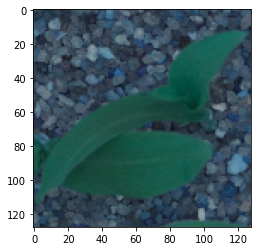

In [32]:
prediction_path=os.path.join(path,"Seedling - Prediction")
image_path=os.path.join(prediction_path,"Predict.png")
image=cv2.resize(cv2.imread(image_path),(128,128))
plt.imshow(image)

In [33]:
final_model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

In [34]:
print("Predicting the test image class")
np.argmax(final_model.predict(tf.expand_dims(image,axis=0)),axis=-1)

Predicting the test image class


array([7], dtype=int64)

In [35]:
classes=np.array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 
         'Common wheat','Fat Hen', 'Loose Silky-bent', 'Maize', 
         'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet'])

In [36]:
# getting the label from the predicted probalilities
print("Test class belongs to {}".format(classes[np.argmax(final_model.predict(tf.expand_dims(image,axis=0)),axis=-1)]))

Test class belongs to ['Maize']
